In [1]:
import random
import cv2 as cv
import numpy as np
import pandas as pd
from collections import deque
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential, load_model

Using TensorFlow backend.
/Users/mitchman/Desktop/MineBrain/mine-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mitchman/Desktop/MineBrain/mine-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mitchman/Desktop/MineBrain/mine-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# Environment

In [342]:
class Maze_Env:
    def __init__(self, columns=5, rows=5, spawns=[(0,0)], goals=[(4,4)], obstacles=[], random_obstacles=0):
        self.n_actions = 4
        self.agent_pose = spawns[0]
        self.spawns = spawns
        self.curr_spawn = 0
        self.goals = {}
        for goal in goals: # This is a key update to the algorithm. Once a target is found finding it again is useless
            self.goals[goal] = 1
        self.obstacles = obstacles
        if random_obstacles:
            for i in range(int(columns * rows / random_obstacles)):
                point = (np.random.randint(0,columns), np.random.randint(0,rows))
                if not point in spawns and not point in goals:
                    self.obstacles.append(point)
        self.size = (columns, rows)
        
    def reset(self, targets):
        self.curr_spawn = (self.curr_spawn + 1) % len(self.spawns)
        self.agent_pose = self.spawns[self.curr_spawn]
        for goal in self.goals:
            self.goals[goal] = 1  
        return self.agent_pose

    def step(self, action):
        pose = self.agent_pose
        if action == 0 and pose[0] + 1 < self.size[0]:
            self.agent_pose = (pose[0] + 1, pose[1])
        elif action == 1 and pose[0] - 1 >= 0:
            self.agent_pose = (pose[0] - 1, pose[1])
        elif action == 2 and pose[1] + 1 < self.size[1]:
            self.agent_pose = (pose[0], pose[1] + 1)
        elif action == 3 and pose[1] - 1 >= 0:
            self.agent_pose = (pose[0], pose[1] - 1)
        if self.agent_pose in self.obstacles:
            return self.agent_pose, -2, 0
        done = 1
        found = 0
        for goal in self.goals:
            if self.agent_pose == goal:
                found = self.goals[goal]
                self.goals[goal] = 0
            if self.goals[goal]:
                done = 0
        return self.agent_pose, found, done
    
    # This function simulates rambo deciding what actions are possible.
    def get_action_mask(self):
        pose = self.agent_pose
        mask = []
        if pose[0] + 1 < self.size[0]:
            mask.append(0)
        if pose[0] - 1 >= 0:
            mask.append(1)
        if pose[1] + 1 < self.size[1]:
            mask.append(2)
        if pose[1] - 1 >= 0:
            mask.append(3)
        return mask
            
    def render(self):
        mark_size = (2000,2000)
        plt.figure(figsize=(8, 8))
        x = []
        y = []
        for pose in self.obstacles:
            c,r = pose
            x.append(c)
            y.append(r)
        plt.scatter(x, y, marker='s', c='black', s=mark_size)
        for goal in self.goals:
            plt.scatter(goal[0], goal[1], marker='s', c='r', s=mark_size)
        for spawn in self.spawns:
            plt.scatter(spawn[0], spawn[1], marker='s', c='g', s=mark_size)
        plt.scatter(self.agent_pose[0], self.agent_pose[1], marker='s', c='b', s=mark_size)
        plt.show()
    
    """ 
    These were used as the original reward functions, it essentially creates a gradiant
        away from the start and towards the goal.
        reward = dist_start - dist_goal / time
        This reward function allows an agent in 5x5 maze with diagonal
        divider to converge in about 20 episodes
        UPDATE: there are now multiple starts and goals
        
    """
    def dist_from_start(self):
        x = (self.spawns[self.curr_spawn][0] - self.agent_pose[0])**2
        y = (self.spawns[self.curr_spawn][1] - self.agent_pose[1])**2
        return np.sqrt(x + y)
    
    def dist_from_goals(self):
        dist = 0
        for goal in self.goals:
            x = (goal[0] - self.agent_pose[0])**2
            y = (goal[1] - self.agent_pose[1])**2
            dist += np.sqrt(x + y)
        return dist / len(self.goals)
        

In [343]:
cols = 5
rows = 5
end_points = [(0,4), (4,0), (4,4)]
obstacles = [(2,3), (3,3), (0,2), (2,2), (2,0), (1,3)]
maze = Maze_Env(columns=cols, rows=rows, obstacles=obstacles, goals=end_points)

## Simple Q 

In [376]:
gamma = .9
alpha = .4
epsilon = 0.9
epsilon_min = 0.01
epsilon_decay = .999
n_episodes = 1000
learner = QLearner(epsilon, epsilon_decay, epsilon_min, gamma, alpha, n_actions=4)

Targets Aquired in 363923 steps
Episode 0 Terminated after 363923 steps, and scored -2401825.7
Targets Aquired in 364024 steps
Episode 1 Terminated after 364024 steps, and scored -3712744.5
Targets Aquired in 364069 steps
Episode 2 Terminated after 364069 steps, and scored -1674694.3
Targets Aquired in 364198 steps
Episode 3 Terminated after 364198 steps, and scored -4734037.500000001
Targets Aquired in 364395 steps
Episode 4 Terminated after 364395 steps, and scored -7213425.9
Targets Aquired in 364614 steps
Episode 5 Terminated after 364614 steps, and scored -8019522.0
Targets Aquired in 364831 steps
Episode 6 Terminated after 364831 steps, and scored -7951543.700000001
Targets Aquired in 365076 steps
Episode 7 Terminated after 365076 steps, and scored -8977936.5
Targets Aquired in 365291 steps
Episode 8 Terminated after 365291 steps, and scored -7888287.0
Targets Aquired in 365650 steps
Episode 9 Terminated after 365650 steps, and scored -13157437.0
Targets Aquired in 365979 steps
E

Targets Aquired in 368309 steps
Episode 154 Terminated after 368309 steps, and scored -441958.0
Targets Aquired in 368320 steps
Episode 155 Terminated after 368320 steps, and scored -441971.20000000007
Targets Aquired in 368331 steps
Episode 156 Terminated after 368331 steps, and scored -441984.4
Targets Aquired in 368342 steps
Episode 157 Terminated after 368342 steps, and scored -441997.60000000003
Targets Aquired in 368353 steps
Episode 158 Terminated after 368353 steps, and scored -442010.80000000005
Targets Aquired in 368364 steps
Episode 159 Terminated after 368364 steps, and scored -442024.0
Targets Aquired in 368375 steps
Episode 160 Terminated after 368375 steps, and scored -442037.20000000007
Targets Aquired in 368386 steps
Episode 161 Terminated after 368386 steps, and scored -442050.4
Targets Aquired in 368397 steps
Episode 162 Terminated after 368397 steps, and scored -442063.60000000003
Targets Aquired in 368408 steps
Episode 163 Terminated after 368408 steps, and scored 

Targets Aquired in 371045 steps
Episode 394 Terminated after 371045 steps, and scored -445241.20000000007
Targets Aquired in 371056 steps
Episode 395 Terminated after 371056 steps, and scored -445254.4
Targets Aquired in 371067 steps
Episode 396 Terminated after 371067 steps, and scored -445267.60000000003
Targets Aquired in 371078 steps
Episode 397 Terminated after 371078 steps, and scored -445280.80000000005
Targets Aquired in 371089 steps
Episode 398 Terminated after 371089 steps, and scored -445294.0
Targets Aquired in 371102 steps
Episode 399 Terminated after 371102 steps, and scored -519537.30000000005
Targets Aquired in 371113 steps
Episode 400 Terminated after 371113 steps, and scored -445322.80000000005
Targets Aquired in 371124 steps
Episode 401 Terminated after 371124 steps, and scored -445336.0
Targets Aquired in 371135 steps
Episode 402 Terminated after 371135 steps, and scored -445349.20000000007
Targets Aquired in 371146 steps
Episode 403 Terminated after 371146 steps, a

Episode 643 Terminated after 373848 steps, and scored -448604.80000000005
Targets Aquired in 373859 steps
Episode 644 Terminated after 373859 steps, and scored -448618.0
Targets Aquired in 373870 steps
Episode 645 Terminated after 373870 steps, and scored -448631.20000000007
Targets Aquired in 373881 steps
Episode 646 Terminated after 373881 steps, and scored -448644.4
Targets Aquired in 373892 steps
Episode 647 Terminated after 373892 steps, and scored -448657.60000000003
Targets Aquired in 373903 steps
Episode 648 Terminated after 373903 steps, and scored -448670.80000000005
Targets Aquired in 373914 steps
Episode 649 Terminated after 373914 steps, and scored -448684.0
Targets Aquired in 373925 steps
Episode 650 Terminated after 373925 steps, and scored -448697.20000000007
Targets Aquired in 373936 steps
Episode 651 Terminated after 373936 steps, and scored -448710.4
Targets Aquired in 373947 steps
Episode 652 Terminated after 373947 steps, and scored -448723.60000000003
Targets Aqui

Episode 893 Terminated after 376660 steps, and scored -451979.20000000007
Targets Aquired in 376671 steps
Episode 894 Terminated after 376671 steps, and scored -451992.4
Targets Aquired in 376682 steps
Episode 895 Terminated after 376682 steps, and scored -452005.60000000003
Targets Aquired in 376693 steps
Episode 896 Terminated after 376693 steps, and scored -452018.8
Targets Aquired in 376704 steps
Episode 897 Terminated after 376704 steps, and scored -452032.0
Targets Aquired in 376715 steps
Episode 898 Terminated after 376715 steps, and scored -452045.20000000007
Targets Aquired in 376726 steps
Episode 899 Terminated after 376726 steps, and scored -452058.4
Targets Aquired in 376737 steps
Episode 900 Terminated after 376737 steps, and scored -452071.60000000003
Targets Aquired in 376748 steps
Episode 901 Terminated after 376748 steps, and scored -452084.8
Targets Aquired in 376759 steps
Episode 902 Terminated after 376759 steps, and scored -452098.0
Targets Aquired in 376770 steps


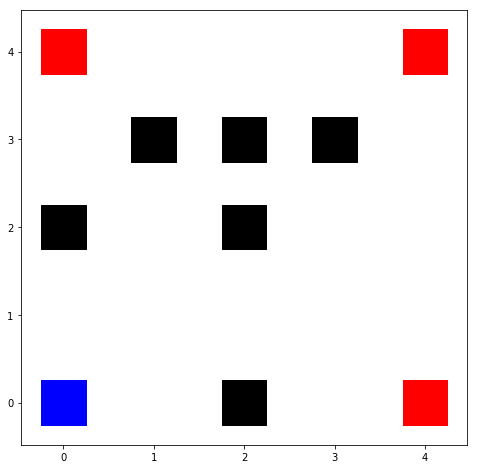

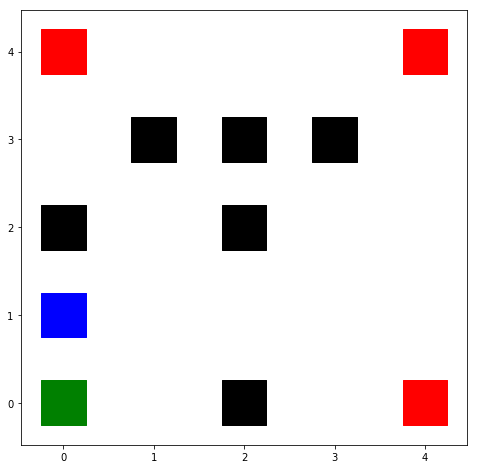

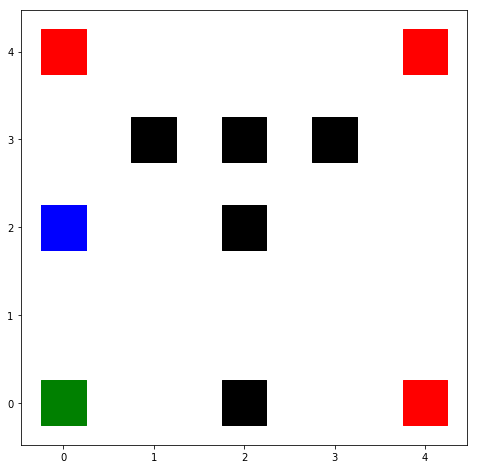

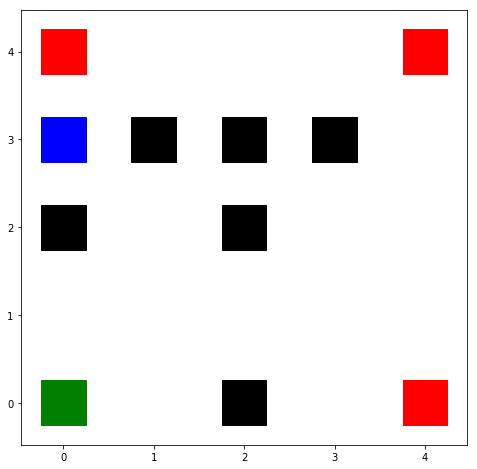

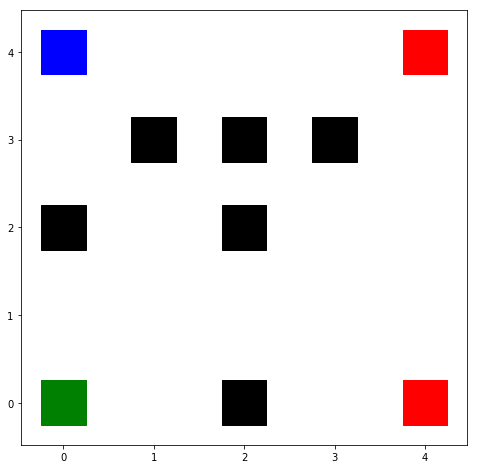

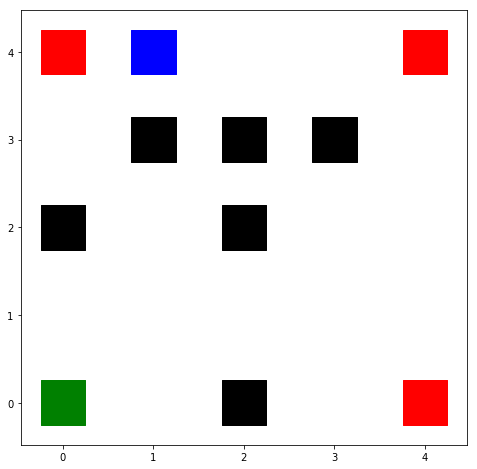

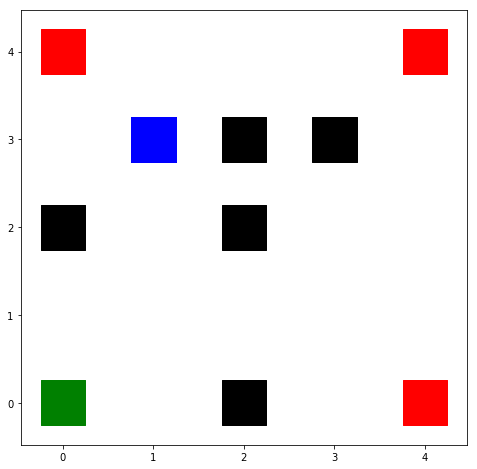

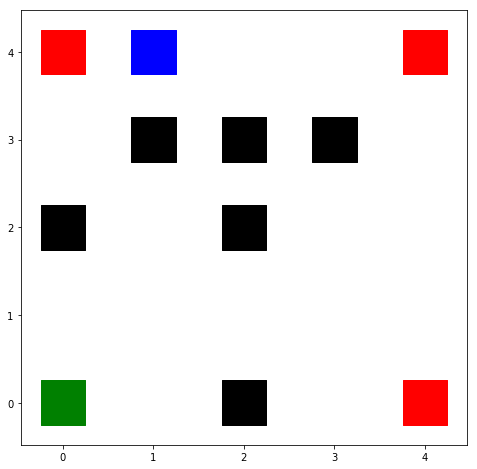

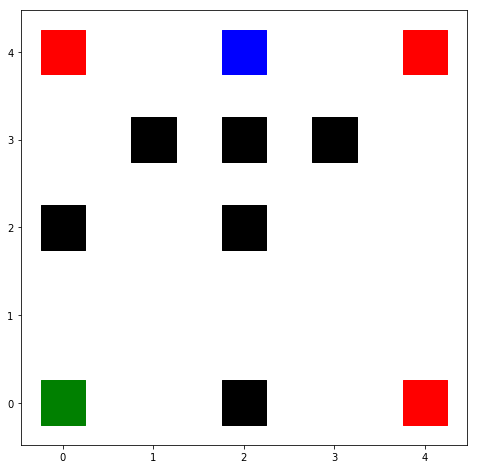

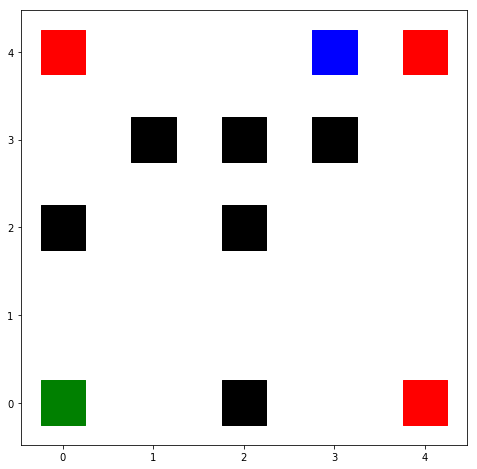

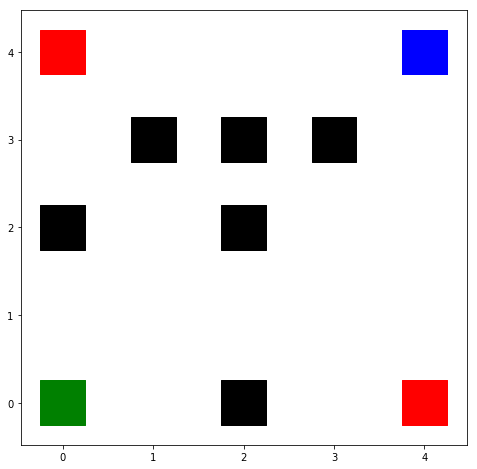

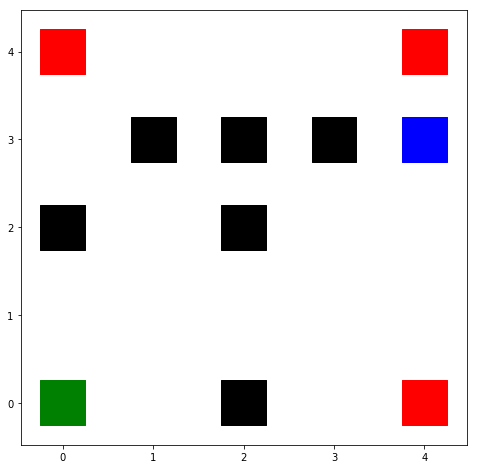

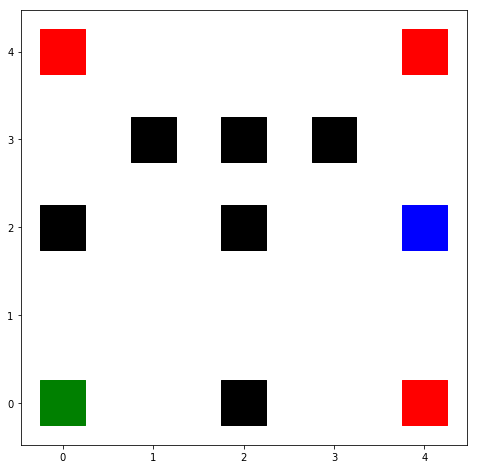

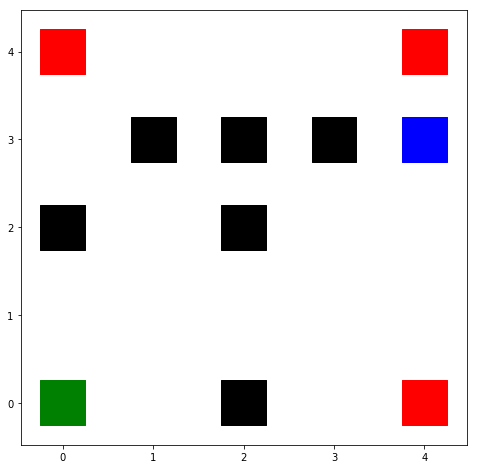

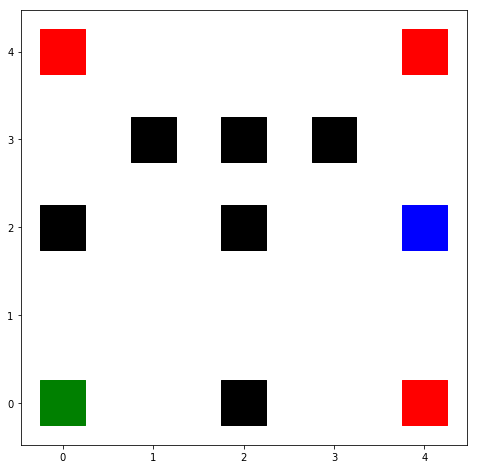

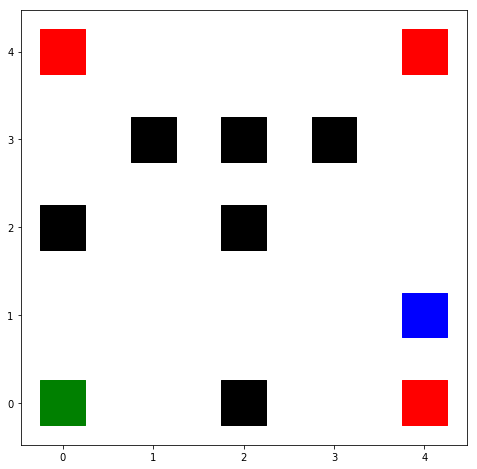

Targets Aquired in 377852 steps
Episode 999 Terminated after 377852 steps, and scored -604554.6
Total Average Time:  372203.54
Average Score:  -556193.2619
Frequencies:  [[  62.    0. 1094.    0.]
 [  37.    0. 1062.   73.]
 [  33.   83.   21.    0.]
 [  12.   27.   11.   24.]
 [   9.    9.   10.   22.]
 [  11.   11.   29.   10.]
 [  66.   51.   20.    0.]
 [  51.   82.   48.    0.]
 [   9.    8.    9.   56.]
 [  22.   11.   11.    6.]
 [  40.    8.   11.    8.]
 [   0.   22.   36. 1040.]
 [   0.   13.   74. 1034.]
 [  15.    9.   14.   25.]
 [1134.   36.    0.   18.]
 [1072.  134.    0.   28.]
 [1040.   47.    0.   38.]
 [1048.    0.    0.  115.]
 [   0.   19.   42. 1032.]
 [   0.   59.   44.    0.]
 [   8.   20.   41.    9.]
 [  22.    0. 1124.   42.]
 [  52.    0. 1053.   51.]
 [  15.   52.    9.    7.]
 [   0.   89.    0. 1045.]]


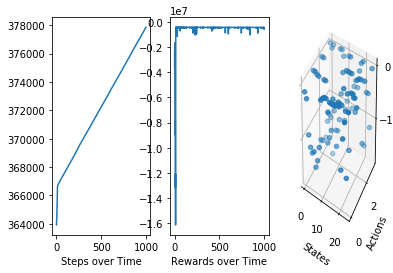

In [377]:
time_steps = []
rewards = []
agent_history = deque(maxlen=4)
done = False
for i in range(n_episodes):
    prev = (0,0)
    pose = maze.reset(end_points)
    p = (pose[0], pose[1])
    state = learner.allocate_state(p)
    reward = 0
    while 1:
        mask = maze.get_action_mask()
        action = learner.epsilon_greedy(state, mask)
        if n_episodes - i < 2:
            maze.render()
        pose, target, done = maze.step(action)
        p = (pose[0], pose[1])
        prev = pose
        new_state = learner.allocate_state(p)
        reward += (target * 5) - (0.1 * t)
        learner.track_event(state, action, new_state, reward)
        state = new_state
        if done:
            print(f'Targets Aquired in {t+1} steps')
            break
        t += 1
    rewards.append(reward)
    time_steps.append(t+1)
    print(f'Episode {i} Terminated after {t+1} steps, and scored {reward}')
learner.display_history(time_steps, rewards)

## Deep Q 

In [252]:
state_size = 2
action_size = 5
batch_size = 21
n_episodes = 1000
gamma = .9
alpha = 1e-6
epsilon = .2
epsilon_min = .01
epsilon_decay = .9
mem_len = 500
agent = DQNAgent(state_size, action_size, alpha, epsilon, epsilon_min, epsilon_decay, gamma, mem_len)

In [253]:
time_steps = []
rewards = []

for i in range(n_episodes):
    st = maze.reset(end_points)
    state = st
    state = np.reshape(state, (1, state_size))
    t = 0
    reward = 0
    while 1:
        if n_episodes - i < 2:
            maze.render()
        mask = maze.get_action_mask()
        action = agent.act(state, mask)
        new_st, target, done = maze.step(action)
        new_state = new_st
        new_state = np.reshape(new_state, (1, state_size))
        reward = (5 * target) - (0.1 * t)
        agent.track_event(state, action, new_state, reward, done)
        state = new_state
        if done:
            time_steps.append(t+1)
            rewards.append(reward)
            print(f'Target Aquired in {t+1} steps')
            break
        t += 1
    agent.replay(np.min([len(agent.memory), batch_size]))
    print(f'Episode {i} Terminated after {t+1} steps, and scored {reward}')
agent.display_history(time_steps, rewards)

KeyboardInterrupt: 

# Agents

In [337]:
class QLearner():

    def __init__(self, epsilon, epsilon_decay, epsilon_min, gamma, alpha, n_bins=-1, bins=[], n_states=0, n_actions=0):
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.alpha = alpha
        self.n_states = n_states
        self.n_actions = n_actions
        if n_bins >= 0:
            self.n_bins = n_bins
            self.init_bins(bins) # helps to classify discrete spans
        self.state_zips = {} # Classifies complex states
        self.history = np.zeros((self.n_states, self.n_actions))
        self.Q_table = np.random.uniform(low=0, high=1, size=(self.n_states, self.n_actions))

    def init_bins(self, spans):
        self.bins = []
        for span in spans:
            width = np.abs(span[0] - span[1]) / self.n_bins
            span = (span[0] - width, span[1] + width)
            self.bins.append(pd.cut(span, bins=self.n_bins, retbins=True)[1][1:-1])

    def adjust_state_space(self):
        self.n_states = len(self.state_zips)
        q_table = np.random.uniform(low=0, high=1, size=(self.n_states, self.n_actions))
        q_table[:-1] = self.Q_table
        self.Q_table = q_table
        hist = np.zeros((self.n_states, self.n_actions))
        hist[:-1] = self.history
        self.history = hist

    def allocate_state(self, complex_s):
        if complex_s in self.state_zips:
            sstate = self.state_zips[complex_s]
        else:
            sstate = len(self.state_zips)
            self.state_zips[complex_s] = sstate
            self.adjust_state_space()
        return sstate

    def zip_observation(self, observation):
        complex_state = 0
        for i,val in enumerate(observation):
            digitized = np.digitize(x=val, bins=self.bins[i]) * (self.n_bins ** i)
            complex_state += digitized
        state = self.allocate_state(complex_state)
        return state
    """
        The below functions give the agent a chance
        to escape his policy, not only in a random direction
        but the least taken direction. The goal is to inspire
        the agent to explore everything.
    """
    def get_best_action(self, state, mask):
        m = np.min(self.Q_table[state])
        action = mask[0]
        for a in mask:
            if self.Q_table[state][a] >= m:
                action = a
                m = self.Q_table[state][a]
        return action
    
    def epsilon_greedy(self, state, mask):
        if np.random.rand() <= self.epsilon:
            action = mask[np.random.randint(len(mask))]
        else:
            action = self.get_best_action(state, mask)
        return action
    
    def frequency(self, state, mask, threashold):
        val = np.max(self.history[state])
        for a in mask:
            if self.history[state][a] <= val:
                action = a
                val = self.history[state][a]
        if val > threashold:
            return self.get_best_action(state, mask)
        return action
    
    def relative_frequency(self, state, mask, threashold0, threashold1):
        total_f = np.sum(self.history[state])
        if total_f > threashold1:
            return self.get_best_action(state, mask)
        for i, a in enumerate(self.history[state]):
            if a / total_f <= threashold0:
                return i
        return self.get_best_action(state, mask)
    
    def update_q_table(self, state, action, new_state, reward, done):
        if done:
            target = 1
        else:
            target = reward + self.gamma * np.max(self.Q_table[new_state])
        self.Q_table[state][action] += self.alpha * (target - self.Q_table[state][action])

    def track_event(self, state, action, new_state, reward, done=0):
        self.history[state][action] += 1
        self.epsilon = max(self.epsilon_decay * self.epsilon, epsilon_min)
        if done:
            self.terminal_states[new_state] = 1
        self.update_q_table(state, action, new_state, reward, done)

    def display_history(self, t_steps, rewards):
        # Plot Info
        print('Total Average Time: ', np.sum(t_steps) / len(t_steps))
        print('Average Score: ', np.sum(rewards) / len(rewards))
        print('Frequencies: ', self.history)
        fig = plt.figure()
        ax0 = fig.add_subplot(131)
        ax1 = fig.add_subplot(132)
        ax2 = fig.add_subplot(133, projection='3d')
        ax0.plot(np.arange(len(t_steps)), t_steps)
        ax0.set_xlabel('Steps over Time')
        ax1.plot(np.arange(len(rewards)), rewards)
        ax1.set_xlabel('Rewards over Time')
        x = []
        y= []
        z = []
        for s in range(self.n_states):
            for a in range(self.n_actions):
                x.append(s)
                y.append(a)
                z.append(self.Q_table[s][a])
        ax2.scatter(x,y,z)
        ax2.set_xlabel('States')
        ax2.set_ylabel('Actions')
        plt.show()
        cv.waitKey()

In [90]:
class DQNAgent:

    def __init__(self, state_size, action_size, alpha, epsilon, epsilon_min, epsilon_decay, gamma, mem_len):
        self.n_states = state_size
        self.n_actions = action_size

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.memory = deque(maxlen=mem_len)

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.n_states, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))
        return model

    def track_event(self, state, action, new_state, reward, done):
        self.memory.append((state, action, new_state, reward, done))

    def act(self, state, mask):
        if np.random.rand() <= self.epsilon:
            rand = np.random.randint(len(mask))
            return mask[rand]
        q_vals = self.model.predict(state)[0]
        m = np.min(q_vals)
        for a in mask:
            if q_vals[a] >= m:
                action = a
                m = q_vals[a]
        return action
          
    def replay(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size) 
        for state, action, next_state, reward, done in mini_batch:
            target = 5
            if not done:
                target = (reward + self.gamma * np.max(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] += self.alpha * target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, filename):
        self.model.load_weights(filename)

    def save(self, fileName):
        self.model.save(filename)
    
    def display_history(self, t_steps, test_steps):
        # Plot Info
        print('Total Average Time: ', np.sum(t_steps) / len(t_steps))
        print('Average Score: ', np.sum(test_steps) / len(test_steps))
        #print('Terminal States:', self.terminal_states)
        #print('Q Table: ', self.Q_table)
        fig = plt.figure()
        ax0 = fig.add_subplot(121)
        ax1 = fig.add_subplot(122, projection='3d')
        ax0.plot(np.arange(len(t_steps)), t_steps)
        ax0.set_xlabel('T_Steps over Time')
        x = []
        y= []
        z = []
        for s in range(self.n_states):
            q_vals = self.model.predict(state)[0]
            for a in range(self.n_actions):
                x.append(s)
                y.append(a)
                z.append(q_vals[a])
        ax1.scatter(x,y,z)
        ax1.set_xlabel('States')
        ax1.set_ylabel('Actions')
        plt.show()
        cv.waitKey()